All plots will be in the same place, will share axes and stuff

In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.ticker as mticker
import matplotlib.ticker as ticker

import seaborn as sns

sns.set_style("whitegrid", {"grid.linestyle":"--"})

In [2]:
# Basically set the args here:
window_start_time = 7800
window_end_time = 8800


lacc_window_start_time = 11200
lacc_window_end_time = lacc_window_start_time + window_end_time - window_start_time
print(lacc_window_end_time)

idm_window_start_time = 50
idm_window_end_time = idm_window_start_time + window_end_time - window_start_time
print(idm_window_end_time)

12200
1050


In [3]:
# get files for each type

# If not to include something, remove from this list
method = ['idm', 'bcm','lacc','fs','pi','wu', 'ours', 'ours4x']

method_file_paths = {}

for m in method:
    file_name = os.listdir('./rollouts_for_stability_plot/' + m + '_stability/')
    file_path = os.path.join('./rollouts_for_stability_plot', f'{m}_stability', file_name[0]) # Will just look at one file for each
    method_file_paths[m] = file_path
    
# for i in method:
#     file_name = os.listdir('./test_time_rollout/' + i +'/')
#     file_path = './test_time_rollout/' + i +'/' + file_name
    
method_file_paths

{'idm': './rollouts_for_stability_plot/idm_stability/idm_20230725-1031591690299119.7012465-0_emission.csv',
 'bcm': './rollouts_for_stability_plot/bcm_stability/bcm_20230725-1043561690299836.8744602-0_emission.csv',
 'lacc': './rollouts_for_stability_plot/lacc_stability/lacc_20230725-1042311690299751.2681942-0_emission.csv',
 'fs': './rollouts_for_stability_plot/fs_stability/fs_20230725-1033151690299195.9457023-0_emission.csv',
 'pi': './rollouts_for_stability_plot/pi_stability/piws_20230725-1034441690299284.5977454-0_emission.csv',
 'wu': './rollouts_for_stability_plot/wu_stability/stabilizing_the_ring_20230725-1036221690299382.5463386-0_emission.csv',
 'ours': './rollouts_for_stability_plot/ours_stability/density_aware_rl_20230725-1406091690311969.3382833-0_emission.csv',
 'ours4x': './rollouts_for_stability_plot/ours4x_stability/density_aware_multiagent_ring_20230803-1052431691077963.148413-0_emission.csv'}

In [4]:
# get data from each file
# For idm, idm_0 is the shocker/ lead for others human_0
# Get shockers, controllers, laggers in separate lists

shockers = []
controllers = [] # IDM only has all controllers except shocker
laggers = [] 

for m in method:
    if m == "lacc": #or "ours": # change this for ours, for a different policy
        window_start = lacc_window_start_time
        window_end = lacc_window_end_time 
#     elif m == "ours":
#         window_start = lacc_window_start_time
#         window_end = lacc_window_end_time
    elif m == "idm":
        window_start = idm_window_start_time
        window_end = idm_window_end_time
    else: 
        window_start = window_start_time
        window_end = window_end_time
    
    dataframe = pd.read_csv(method_file_paths.get(m))
    
    vehicle_ids = dataframe['id'].unique()
    
    controller_method = []
    lagger_method = []
    
    for vehicle in vehicle_ids:
        #print(vehicle, type(vehicle))
        if m =="idm":
            speed = dataframe[dataframe['id'] == vehicle]['speed'][window_start:window_end]
            if "idm_0" in vehicle:
                shockers.append(speed)
            else: 
                controller_method.append(speed)
                
        elif m=="ours4x":
            speed = dataframe[dataframe['id'] == vehicle]['speed'][window_start:window_end]
            
            if "human_3_0" in vehicle: # human_3_0, human_3_1
                shockers.append(speed)
                
            elif "human" not in vehicle:
                controller_method.append(speed)
                
            else: 
                #print(vehicle)
                lagger_method.append(speed)
                
        else:   
            speed = dataframe[dataframe['id'] == vehicle]['speed'][window_start:window_end]
            if "human_0" in vehicle:
                shockers.append(speed)
                
            elif "human" not in vehicle:
                controller_method.append(speed)
            
            else: 
                #print(vehicle)
                lagger_method.append(speed)
                
    controller_method = np.array(controller_method)
    controllers.append(controller_method.astype(object)) 
    
    lagger_method = np.array(lagger_method)
    laggers.append(lagger_method.astype(object))
    
    #print(controller_method.shape)
    #print(lagger_method.shape)
    
shockers = np.array(shockers)
controllers = np.array(controllers, dtype=object)
laggers = np.array(laggers, dtype = object)

print(shockers.shape)
print(controllers.shape) 
print(laggers.shape)

# Apply window

(8, 1000)
(8,)
(8,)


['780' '800' '820' '840' '860' '880']
['1120' '1140' '1160' '1180' '1200' '1220']
['5' '25' '45' '65' '85' '105']


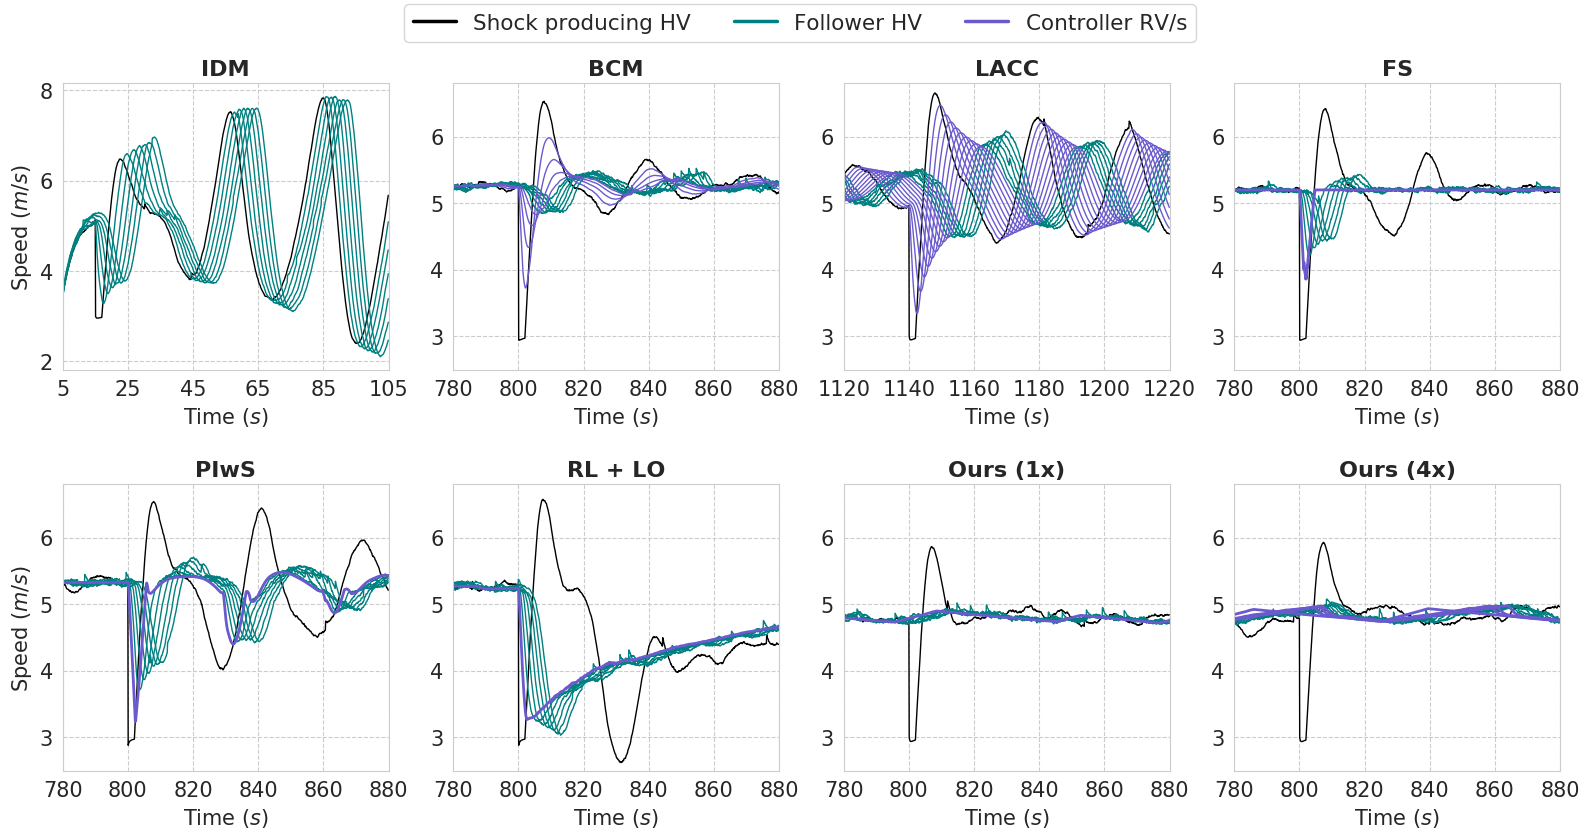

In [5]:
x_ticks_others = np.linspace(window_start_time/10, (window_end_time + 1)/10, 6).astype(int).astype(str)
print(x_ticks_others)

x_ticks_lacc = np.linspace(lacc_window_start_time/10, (lacc_window_end_time+1)/10, 6).astype(int).astype(str)
print(x_ticks_lacc)

x_ticks_idm = np.linspace(idm_window_start_time/10, (idm_window_end_time+1)/10, 6).astype(int).astype(str)
print(x_ticks_idm)

num_humans_to_display = 6
rows = 2
cols = 4

lenghts = len(method)


fig, ax = plt.subplots(nrows= rows, ncols=cols ,figsize=(16,8), dpi=100, sharey=False)
#fig.delaxes(ax[1,3])
ax = ax.flatten()[:lenghts]

ax[0].yaxis.set_major_locator(ticker.MultipleLocator(2))

fs = 15 
for i in range(lenghts):
    #print(i)
    name = method[i]
    
    if name =="bcm" or name =="lacc":
        lw = 1
    else:
        lw = 2
        
    ax[i].plot(shockers[i], color='black', linewidth=1)
    
    if name !="idm": # CUZ idm has all controllers
        # plot laggers
        for j in range(num_humans_to_display):
            # count humans behind controllers from last 
            c = laggers[i].shape[0] - j -1
            ax[i].plot(laggers[i][c], color='teal', linewidth=1)
            
    if name =="idm":
        for k in range(num_humans_to_display):
            m = controllers[i].shape[0] - k -1
            ax[i].plot(controllers[i][m], color='teal', linewidth=1)
    else: 
        # plot controllers
        for k in range(len(controllers[i])):
            ax[i].plot(controllers[i][k], color='slateblue', linewidth=lw)
    
    if name =="wu":
        ax[i].set_title("RL + LO", fontsize = fs+1, fontweight="bold")
    elif name =="pi":
        ax[i].set_title("PIwS", fontsize = fs+1, fontweight="bold")
    elif name =="ours":
        ax[i].set_title("Ours (1x)", fontsize = fs+1, fontweight="bold")
    elif name =="ours4x":
        ax[i].set_title("Ours (4x)", fontsize = fs+1, fontweight="bold")
    else: 
        ax[i].set_title(name.upper(), fontsize = fs+1, fontweight="bold")
    
    ax[i].set_xlabel("Time $(s)$", fontsize = fs)
    ax[i].set_xlim([0, 1000])

    if name =="lacc":
        xticks = x_ticks_lacc#["1140", "1160", "1180", "1200", "1220", "1240"]
        
    elif name =="idm":
        xticks = x_ticks_idm
    else: 
        xticks = x_ticks_others#["780", "800", "820", "840", "860", "880"]
    ax[i].set_xticklabels(xticks, fontsize=fs)
    
    
    
ax[0].set_ylabel("Speed $(m/s)$", fontsize = fs)
ax[4].set_ylabel("Speed $(m/s)$", fontsize = fs)

for i in range(1,8):
    if i<6:
        ax[i].set_ylim([2.5, 6.8])
    else:
        ax[i].set_ylim([2.5, 6.8])
for i in range(lenghts):
    ax[i].tick_params(axis='both', which='major', labelsize=fs)
    
# Add the legend
lw_legend = 2.5
legend_elements = [Line2D([0], [0], color='black', label='Shock producing HV', linewidth=lw_legend),
                   Line2D([0], [0], color='teal', label='Follower HV', linewidth=lw_legend),
                   Line2D([0], [0], color='slateblue', label='Controller RV/s', linewidth=lw_legend)]

#fig.legend(handles=legend_elements, loc='lower right', fontsize=fs+1, ncol=1)
fig.legend(handles=legend_elements, loc='center', bbox_to_anchor=(0.5, 1.02), fontsize=fs+0.5, ncol=3)


plt.tight_layout()
#plt.subplots_adjust(bottom=2.55)
plt.subplots_adjust(hspace = 0.4)
plt.savefig('./stability.pdf')
plt.show()

In [6]:
# lookout_time = 200 # timesteps ahead and behind the shock 
# i = 0 
# fontsize = 16

# dampening_ratio_mother= []

# # Generate for each rollout file that was found  
# for file in self.kwargs['files']:
# self.dataframe = pd.read_csv(file)
# self.vehicle_ids = self.dataframe['id'].unique()
# print(f"Vehicles: {self.vehicle_ids}")

# # add if human in id
# n_human = len([item for item in self.vehicle_ids if 'human' in item])
# print(f"Number of human vehicles: {n_human}")

# controlled = [item for item in self.vehicle_ids if 'human' not in item]
# n_controlled = len(controlled)
# print(f"Number of controlled vehicles: {n_controlled}")

# controlled_name = controlled[0].split('_')[0]
# print(f"Controlled vehicle name: {controlled_name}")

# if controlled_name == 'idm':
#     shocker = 'idm_0'
#     sorted_ids = ['idm_0'] + [f'{controlled_name}_{item}' for item in range(1, n_controlled)]
#     end = n_controlled
# else: 
#     shocker = 'human_0'
#     sorted_ids = ['human_0'] + [f'{controlled_name}_{item}' for item in range(n_controlled)]
#     sorted_ids = sorted_ids + [f'human_{item}' for item in range(n_human - 1, 0, -1)]
#     end = n_controlled + 1

# print(f"Sorted ids: {sorted_ids}")

# # Speed of all vehicles across time, for one file
# speeds_total = []
# for vehicle_id in sorted_ids:
#     speed = self.dataframe[self.dataframe['id'] == vehicle_id]['speed']
#     # speed in the time window
#     speed = speed[self.args.start_time - lookout_time : self.args.end_time - 10*lookout_time]
#     speeds_total.append(speed)

# speeds_total = np.array(speeds_total)
# print(f"Speeds total: {speeds_total.shape}\n")

# fig, ax = plt.subplots(figsize=(16, 5), dpi =100)

# # plot leader
# ax.plot(speeds_total[0], label='Leading human', color='black')

# # plot controlled 
# for j in range(1, end):
#     ax.plot(speeds_total[j], color='slateblue') # , label=f'{controlled_name}_{j - 1}',

# if controlled_name != 'idm':
#     # plot all followers
#     for k in range(n_controlled + 1, speeds_total.shape[0]):
#         ax.plot(speeds_total[k], color='teal') #  label=f'Human_{k - n_controlled}'
#     ax.plot([], [], label=f'Follower human', color='teal') 

# # Add a label for each color black, slateblue, teal
# ax.plot([], [], label=f'{controlled_name}', color='slateblue')

# ax.legend()
# ax.set_xlabel('Timesteps')
# ax.set_ylabel('Speed (m/s)')
# ax.set_title(f'{self.method_name}: Stability plot for rollout {i}')
# ax.yaxis.grid(True)

# # Set font sizes
# ax.xaxis.label.set_size(fontsize)
# ax.yaxis.label.set_size(fontsize)
# ax.title.set_size(fontsize)

# # Set legend font size
# for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
#             ax.get_xticklabels() + ax.get_yticklabels()):
#     item.set_fontsize(fontsize)

# plt.tight_layout()
# plt.savefig(self.save_dir + f'/stability_{i}.png')
# i+=1 

# # Calculate the metric (Damping/ Wave attenuation ratio) between human_0 and human_9
# lowest_speed_lead = np.min(speeds_total[0])
# print(f"Lowest speed of lead (index 0): {lowest_speed_lead}")
# if controlled_name == 'idm':
#     lowest_speed_follow = np.min(speeds_total[2])
#     print(f"Lowest speed of follow (index 2): {lowest_speed_follow}")
# else:
#     lowest_speed_follow = np.min(speeds_total[end])
#     print(f"Lowest speed of follow (index {end}): {lowest_speed_follow}")



# dampening_ratio = lowest_speed_lead / lowest_speed_follow
# dampening_ratio_mother.append(dampening_ratio)